In [3]:
import sys
sys.path.append('../')

%load_ext autoreload
%autoreload 2

In [211]:
import pandas as pd
import sqlite3
import os
from tqdm import tqdm
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt

In [43]:
fname = "/home/boris/Data/SIFTS/pdb_chain_uniprot.csv"
sifts_df = pd.read_csv(fname, comment='#')
sifts_df

,PDB,CHAIN,SP_PRIMARY,RES_BEG,RES_END,PDB_BEG,PDB_END,SP_BEG,SP_END
0,101m,A,P02185,1,154,0,153,1,154
1,102l,A,P00720,1,40,1,40,1,40
2,102l,A,P00720,42,165,41,None,41,164
3,102m,A,P02185,1,154,0,153,1,154
4,103l,A,P00720,1,40,1,None,1,40
...,...,...,...,...,...,...,...,...,...
635822,9xia,A,P24300,1,388,1,None,1,388
635823,9xim,A,P12851,1,393,None,394,2,394
635824,9xim,B,P12851,1,393,None,394,2,394
635825,9xim,C,P12851,1,393,None,394,2,394


In [6]:
con = sqlite3.connect("/home/boris/Data/ChemBL/chembl_30/chembl_30_sqlite/chembl_30.db")

In [7]:
cursor = con.cursor()
cursor.execute("create table if not exists sifts (pdb text, chain text sp_primary text, res_beg integer, res_end integer, pdb_beg integer, pdb_end integer, sp_beg integer, sp_end integer)")
cursor.fetchall()

sifts_df.to_sql('sifts', con, if_exists='replace', index=False)
pd.read_sql_query("select * from sifts", con)

,PDB,CHAIN,SP_PRIMARY,RES_BEG,RES_END,PDB_BEG,PDB_END,SP_BEG,SP_END
0,101m,A,P02185,1,154,0,153,1,154
1,102l,A,P00720,1,40,1,40,1,40
2,102l,A,P00720,42,165,41,None,41,164
3,102m,A,P02185,1,154,0,153,1,154
4,103l,A,P00720,1,40,1,None,1,40
...,...,...,...,...,...,...,...,...,...
635822,9xia,A,P24300,1,388,1,None,1,388
635823,9xim,A,P12851,1,393,None,394,2,394
635824,9xim,B,P12851,1,393,None,394,2,394
635825,9xim,C,P12851,1,393,None,394,2,394


In [8]:
crossdocked_types = "/home/boris/Data/CrossDocked/types/it2_tt_v1.1_completeset_test0.types_filtered.types"
crossdocked = pd.read_csv(crossdocked_types, sep=' ', names=["label", "binding_affinity", "crystal_rmsd", "rec_file", "lig_file", "vina_score"])

cd_pdbs = crossdocked['rec_file'].apply(lambda f: f.split('/')[-1].split('_')[0])
cd_chains = crossdocked['rec_file'].apply(lambda f: f.split('/')[-1].split('_')[1])

cd_chains_str = ", ".join(map(lambda s: f"'{s}'", cd_chains))
cd_pdbs_str = ", ".join(map(lambda s: f"'{s}'", cd_pdbs))

crossdocked_uniprots = pd.read_sql_query(f"select SP_PRIMARY from sifts where PDB in ({cd_pdbs_str})", con)
cd_uniprots_str = ", ".join(map(lambda s: f"'{s}'", crossdocked_uniprots["SP_PRIMARY"]))

In [102]:
%%time
query =   f"""

SELECT md.chembl_id AS compound_chembl_id,
cs.canonical_smiles,
act.standard_type,
act.standard_relation,
act.standard_value,
act.standard_units,
act.pchembl_value,
a.confidence_score,
td.chembl_id AS target_chembl_id,
td.target_type,
c.accession as protein_accession,
a.chembl_id as assay_id
FROM target_dictionary td
  JOIN assays a ON td.tid = a.tid
  JOIN activities act ON a.assay_id = act.assay_id
  JOIN molecule_dictionary md ON act.molregno = md.molregno
  JOIN compound_structures cs ON md.molregno = cs.molregno
  JOIN target_type tt ON td.target_type = tt.target_type
  JOIN target_components tc ON td.tid = tc.tid
  JOIN component_sequences c ON tc.component_id = c.component_id
  AND tt.parent_type  = 'PROTEIN' 
  AND act.potential_duplicate = 0
  AND a.confidence_score >= 8
  AND act.data_validity_comment IS NULL
  AND act.pchembl_value IS NOT NULL
  AND c.accession in ({cd_uniprots_str});
  
"""
filename = "/home/boris/Data/BigBind/activities.csv"
with open(filename, 'w'): pass

chunks = pd.read_sql_query(query,con,chunksize=1000)
header = True
for i, chunk in enumerate(chunks):

    chunk.to_csv(filename, header=header, mode='a', index=False)

    header = False
    # if i > 0:
    #     break

chunk

CPU times: user 1min 17s, sys: 36.4 s, total: 1min 54s
Wall time: 19min 59s


,compound_chembl_id,canonical_smiles,standard_type,standard_relation,standard_value,standard_units,pchembl_value,confidence_score,target_chembl_id,target_type,protein_accession,assay_id
0,CHEMBL4783132,N#Cc1cc(F)cc(CNc2ccc3[nH]nc(/C=C/c4ccccn4)c3c2)c1,IC50,=,4.5,nM,8.35,9,CHEMBL5608,SINGLE PROTEIN,Q16288,CHEMBL4772614
1,CHEMBL4780099,C[C@H](Nc1ccc2[nH]nc(/C=C/c3ccccn3)c2c1)c1cc(F...,IC50,=,30.0,nM,7.52,9,CHEMBL5608,SINGLE PROTEIN,Q16288,CHEMBL4772614
2,CHEMBL4792981,C[C@@H](Nc1ccc2[nH]nc(/C=C/c3ccccn3)c2c1)c1cc(...,IC50,=,2.0,nM,8.70,9,CHEMBL5608,SINGLE PROTEIN,Q16288,CHEMBL4772614
3,CHEMBL3889654,O=C(Nc1cnn2ccc(N3CCC[C@@H]3c3cc(F)ccc3F)nc12)N...,IC50,=,1.7,nM,8.77,9,CHEMBL5608,SINGLE PROTEIN,Q16288,CHEMBL4772614
4,CHEMBL4792981,C[C@@H](Nc1ccc2[nH]nc(/C=C/c3ccccn3)c2c1)c1cc(...,Kd,=,150.0,nM,6.82,9,CHEMBL4247,SINGLE PROTEIN,Q9UM73,CHEMBL4772646
...,...,...,...,...,...,...,...,...,...,...,...,...
647,CHEMBL4779427,Cc1[nH]c(/C=C2\C(=O)Nc3ccc(C(=O)N[C@@H](Cc4ccc...,IC50,=,23000.0,nM,4.64,9,CHEMBL3711550,SINGLE PROTEIN,P21146,CHEMBL4775830
648,CHEMBL4786846,Cc1[nH]c(/C=C2\C(=O)Nc3ccc(C(=O)NC4(Cc5ccccc5)...,IC50,=,15000.0,nM,4.82,9,CHEMBL3711550,SINGLE PROTEIN,P21146,CHEMBL4775830
649,CHEMBL4791260,Cc1[nH]c(/C=C2\C(=O)Nc3ccc(C(=O)N[C@H](C)c4ccc...,Ki,=,1000.0,nM,6.00,9,CHEMBL5678,SINGLE PROTEIN,P34947,CHEMBL4775836
650,CHEMBL4785430,Cc1[nH]c(/C=C2\C(=O)Nc3ccc(C(=O)N[C@H](C)c4ccc...,Ki,=,110.0,nM,6.96,9,CHEMBL5678,SINGLE PROTEIN,P34947,CHEMBL4775836


In [170]:
df = pd.read_csv(filename)

In [171]:
df[df["compound_chembl_id"] == "CHEMBL17"][df["protein_accession"] == "P00918"]

/tmp/ipykernel_509453/4080531838.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df["compound_chembl_id"] == "CHEMBL17"][df["protein_accession"] == "P00918"]


,compound_chembl_id,canonical_smiles,standard_type,standard_relation,standard_value,standard_units,pchembl_value,confidence_score,target_chembl_id,target_type,protein_accession,assay_id
6320,CHEMBL17,NS(=O)(=O)c1cc(Cl)c(Cl)c(S(N)(=O)=O)c1,IC50,=,38.0,nM,7.42,8,CHEMBL205,SINGLE PROTEIN,P00918,CHEMBL657919
6325,CHEMBL17,NS(=O)(=O)c1cc(Cl)c(Cl)c(S(N)(=O)=O)c1,IC50,=,40.0,nM,7.40,8,CHEMBL205,SINGLE PROTEIN,P00918,CHEMBL657920
69323,CHEMBL17,NS(=O)(=O)c1cc(Cl)c(Cl)c(S(N)(=O)=O)c1,Ki,=,8.0,nM,8.10,9,CHEMBL205,SINGLE PROTEIN,P00918,CHEMBL840150
121545,CHEMBL17,NS(=O)(=O)c1cc(Cl)c(Cl)c(S(N)(=O)=O)c1,Ki,=,9.0,nM,8.05,9,CHEMBL205,SINGLE PROTEIN,P00918,CHEMBL935610
615043,CHEMBL17,NS(=O)(=O)c1cc(Cl)c(Cl)c(S(N)(=O)=O)c1,Ki,=,1200.0,nM,5.92,9,CHEMBL205,SINGLE PROTEIN,P00918,CHEMBL3269990
811097,CHEMBL17,NS(=O)(=O)c1cc(Cl)c(Cl)c(S(N)(=O)=O)c1,Ki,=,38.0,nM,7.42,9,CHEMBL205,SINGLE PROTEIN,P00918,CHEMBL4142346


In [181]:
vars = []
cvars = []
dfs = df.sample(frac=1)
chembl_values = 10**(9-dfs["pchembl_value"])
for cid in tqdm(dfs["compound_chembl_id"].unique()):
    idxs = dfs["compound_chembl_id"] == cid
    rows = dfs[idxs]
    if len(rows) == 1: continue
    vars.append(rows["pchembl_value"].var())
    cvars.append(chembl_values[idxs].var())

100%|███████████████████████████████████████████████████████████████████████████████| 504707/504707 [11:16:25<00:00, 12.44it/s]


In [185]:
chembl_values.std()

63314.919721926395

In [186]:
np.sqrt(np.array(cvars)).mean()

8409.876620657256

In [182]:
print(np.array(vars).mean()/df["pchembl_value"].var())
print(np.array(cvars).mean()/chembl_values.var())

0.2872843209836886
0.6343119431000392


In [189]:
print(np.sqrt(np.array(vars).mean())/df["pchembl_value"].std())
print(np.sqrt(np.array(vars).mean())/chembl_values.std())

0.5359891052845092
1.2396465955446358e-05


In [9]:
con.close()

In [181]:
from collections import defaultdict
from traceback import print_exc
from bigbind import *

In [21]:
df = get_crossdocked_df()

In [56]:
chain2uniprot = {}
for i, row in sifts_df.iterrows():
    chain2uniprot[(row["PDB"], row["CHAIN"])] = row["SP_PRIMARY"]

In [224]:
uniprot2recs = defaultdict(set)
uniprot2ligs = defaultdict(set)
uniprot2pockets = defaultdict(set)
pocket2recs = defaultdict(set)
pocket2ligs = defaultdict(set)
for lig_file_g in tqdm(df["lig_file"]):
    dir = "/home/boris/Data/CrossDocked/"
    folder, file = lig_file_g.split("/")
    pocket = folder
    rec_id, rec_chain, _, lig_id, lig_name, *rest = file.split("_")
    rec_file = f"{dir}/{folder}/{rec_id}_{rec_chain}_rec.pdb"
    lig_file = f"{dir}/{folder}/{lig_id}_{lig_name}_lig.pdb"
    key = (rec_id, rec_chain)
    if key in chain2uniprot:
        uniprot = chain2uniprot[key]
        uniprot2recs[uniprot].add(rec_file)
        uniprot2ligs[uniprot].add(lig_file)
        uniprot2pockets[uniprot].add(pocket)
    pocket2recs[pocket].add(rec_file)
    pocket2ligs[pocket].add(lig_file)

100%|██████████████████████████████████████████████████████████████████████████████| 290956/290956 [00:00<00:00, 433355.58it/s]


In [257]:
mol = Chem.MolFromMolFile("/home/boris/Data/BigBind/Q9Y478/4qfr_32j_lig.mol2")
mol

In [246]:
pdb_lig_df = pd.read_csv("/home/boris/Data/Components-smiles-stereo-oe.smi", header=None, sep="\t", names=["smiles", "id", "name"])
pdb_lig_df.set_index("id", inplace=True)
pdb_lig_df['smiles']['32J']

'c1ccc(c(c1)c2ccc(cc2)c3c4c(sc3Cl)NC(=O)C(=C4O)C#N)O'

In [ ]:
outputs = []

for uniprot in tqdm(uniprot2recs):
    try:
        recs = uniprot2recs[uniprot]
        ligs = uniprot2ligs[uniprot]
        outputs.append(get_pocket(uniprot, recs, ligs, pdb_lig_df))
    except KeyboardInterrupt:
        raise
    except:
        print_exc()

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
        0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
        0.77, 0.78, 0.79, 0.8 , 

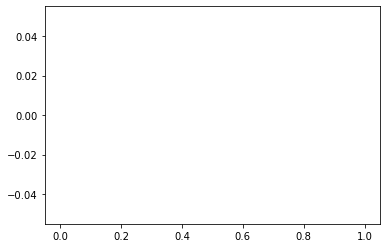

In [261]:
n_residues = []
for r, l, n in outputs:
    n_residues += n
plt.hist(n_residues, bins=100)

In [201]:
struct_data = {
    "uniprot": [],
    "lig_file": [],
    "rec_file": [],
    "num_rec_residues": []
}
for output in outputs:
    lig_files, rec_files, res_nums = output
    for rec, res_num in zip(rec_files, res_nums):
        for lig in lig_files:
            uniprot = lig.split("/")[-2]
            lig = "/".join(lig.split("/")[-2:])
            rec = "/".join(rec.split("/")[-2:])
            struct_data["uniprot"].append(uniprot)
            struct_data["lig_file"].append(lig)
            struct_data["rec_file"].append(rec)
            struct_data["num_rec_residues"].append(res_num)

In [202]:
struct_df = pd.DataFrame(struct_data)
struct_df

,uniprot,lig_file,rec_file,num_rec_residues
0,Q9Y478,Q9Y478/4cfe_992_lig.sdf,Q9Y478/5ezv_B_rec_pocket.pdb,50
1,Q9Y478,Q9Y478/4qfr_32j_lig.sdf,Q9Y478/5ezv_B_rec_pocket.pdb,50
2,Q9Y478,Q9Y478/4cfe_992_lig.sdf,Q9Y478/5ezv_D_rec_pocket.pdb,17
3,Q9Y478,Q9Y478/4qfr_32j_lig.sdf,Q9Y478/5ezv_D_rec_pocket.pdb,17
4,Q9Y478,Q9Y478/4cfe_992_lig.sdf,Q9Y478/4cfe_B_rec_pocket.pdb,17
...,...,...,...,...
280203,P77173,P77173/1y2g_cl3_lig.sdf,P77173/1s1j_B_rec_pocket.pdb,49
280204,P77173,P77173/1y2f_wai_lig.sdf,P77173/1y2f_A_rec_pocket.pdb,32
280205,P77173,P77173/1y2g_cl3_lig.sdf,P77173/1y2f_A_rec_pocket.pdb,32
280206,P77173,P77173/1y2f_wai_lig.sdf,P77173/1s1s_B_rec_pocket.pdb,31


In [269]:
len(struct_df["rec_file"].unique())

15485

In [264]:
rdkit_loadable = {}
rdkit_embeddable = {}
for lig_file in tqdm(struct_df["lig_file"].unique()):
    file = f"/home/boris/Data/BigBind/{lig_file}"
    try:
        mol =  next(Chem.SDMolSupplier(file))
    except OSError:
        loadable = False
        embeddable = False
    if mol is None:
        loadable = False
        embeddable = False
    else:
        loadable = True
        id = AllChem.EmbedMolecule(mol)
        embeddable = (id != -1)
    rdkit_loadable[lig_file] = loadable
    rdkit_embeddable[lig_file] = embeddable

  2%|██▏                                                                                    | 239/9640 [00:05<07:41, 20.37it/s][16:30:02] UFFTYPER: Unrecognized hybridization for atom: 2
[16:30:02] UFFTYPER: Unrecognized atom type: Ru (2)
 15%|█████████████▏                                                                        | 1474/9640 [01:17<04:14, 32.05it/s][16:31:14] UFFTYPER: Unrecognized charge state for atom: 4
[16:31:14] UFFTYPER: Unrecognized atom type: S_5+4 (16)
 15%|█████████████▏                                                                        | 1478/9640 [01:18<12:16, 11.08it/s][16:31:15] UFFTYPER: Unrecognized charge state for atom: 24
[16:31:15] UFFTYPER: Unrecognized charge state for atom: 20
[16:31:15] UFFTYPER: Unrecognized charge state for atom: 24
 15%|█████████████▏                                                                        | 1481/9640 [01:19<13:55,  9.77it/s][16:31:15] UFFTYPER: Unrecognized charge state for atom: 21
[16:31:15] UFFTYPER: Unre

In [ ]:
struct_df["lig_rdkit_loadable"] = np.zeros((len(struct_df),), dtype=bool)
struct_df["lig_rdkit_embeddable"] = np.zeros((len(struct_df),), dtype=bool)
for i, lig_file in enumerate(tqdm(struct_df["lig_file"])):
    struct_df["lig_rdkit_loadable"][i] = rdkit_loadable[lig_file]
    struct_df["lig_rdkit_embeddable"][i] = rdkit_embeddable[lig_file]
struct_df

In [284]:
struct_fname = "/home/boris/Data/BigBind/structures.csv"
struct_df.to_csv(struct_fname, index=False)

In [288]:
activities = pd.read_csv("/home/boris/Data/BigBind/activities.csv")
activities

,compound_chembl_id,canonical_smiles,standard_type,standard_relation,standard_value,standard_units,pchembl_value,confidence_score,target_chembl_id,target_type,protein_accession,assay_id
0,CHEMBL1627453,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1C[C@...,IC50,=,420.0,nM,6.38,8,CHEMBL3181,SINGLE PROTEIN,P14061,CHEMBL615175
1,CHEMBL1627455,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1C[C@...,IC50,=,1000.0,nM,6.00,8,CHEMBL3181,SINGLE PROTEIN,P14061,CHEMBL615175
2,CHEMBL1627884,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1C[C@...,IC50,=,4300.0,nM,5.37,8,CHEMBL3181,SINGLE PROTEIN,P14061,CHEMBL615175
3,CHEMBL1627451,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1C[C@...,IC50,=,1150.0,nM,5.94,8,CHEMBL3181,SINGLE PROTEIN,P14061,CHEMBL615175
4,CHEMBL542453,C=CCN(C)CCCCCCOc1ccc(C(=O)c2ccc([N+](=O)[O-])c...,IC50,=,1.9,nM,8.72,8,CHEMBL3593,SINGLE PROTEIN,P48449,CHEMBL615200
...,...,...,...,...,...,...,...,...,...,...,...,...
895647,CHEMBL4779427,Cc1[nH]c(/C=C2\C(=O)Nc3ccc(C(=O)N[C@@H](Cc4ccc...,IC50,=,23000.0,nM,4.64,9,CHEMBL3711550,SINGLE PROTEIN,P21146,CHEMBL4775830
895648,CHEMBL4786846,Cc1[nH]c(/C=C2\C(=O)Nc3ccc(C(=O)NC4(Cc5ccccc5)...,IC50,=,15000.0,nM,4.82,9,CHEMBL3711550,SINGLE PROTEIN,P21146,CHEMBL4775830
895649,CHEMBL4791260,Cc1[nH]c(/C=C2\C(=O)Nc3ccc(C(=O)N[C@H](C)c4ccc...,Ki,=,1000.0,nM,6.00,9,CHEMBL5678,SINGLE PROTEIN,P34947,CHEMBL4775836
895650,CHEMBL4785430,Cc1[nH]c(/C=C2\C(=O)Nc3ccc(C(=O)N[C@H](C)c4ccc...,Ki,=,110.0,nM,6.96,9,CHEMBL5678,SINGLE PROTEIN,P34947,CHEMBL4775836


In [ ]:
rdkit_loadable = []
rdkit_embeddable = []
for smiles in tqdm(activities["canonical_smiles"]):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        loadable = False
        embeddable = False
    else:
        loadable = True
        id = AllChem.EmbedMolecule(mol)
        embeddable = (id != -1)
    rdkit_loadable.append(loadable)
    rdkit_embeddable.append(embeddable)

In [291]:
activities = pd.read_csv("/home/boris/Data/BigBind/activities.csv")
activities

,compound_chembl_id,canonical_smiles,standard_type,standard_relation,standard_value,standard_units,pchembl_value,confidence_score,target_chembl_id,target_type,protein_accession,assay_id,is_test
0,CHEMBL1627453,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1C[C@...,IC50,=,420.0,nM,6.38,8,CHEMBL3181,SINGLE PROTEIN,P14061,CHEMBL615175,False
1,CHEMBL1627455,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1C[C@...,IC50,=,1000.0,nM,6.00,8,CHEMBL3181,SINGLE PROTEIN,P14061,CHEMBL615175,False
2,CHEMBL1627884,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1C[C@...,IC50,=,4300.0,nM,5.37,8,CHEMBL3181,SINGLE PROTEIN,P14061,CHEMBL615175,False
3,CHEMBL1627451,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1C[C@...,IC50,=,1150.0,nM,5.94,8,CHEMBL3181,SINGLE PROTEIN,P14061,CHEMBL615175,False
4,CHEMBL542453,C=CCN(C)CCCCCCOc1ccc(C(=O)c2ccc([N+](=O)[O-])c...,IC50,=,1.9,nM,8.72,8,CHEMBL3593,SINGLE PROTEIN,P48449,CHEMBL615200,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
895647,CHEMBL4779427,Cc1[nH]c(/C=C2\C(=O)Nc3ccc(C(=O)N[C@@H](Cc4ccc...,IC50,=,23000.0,nM,4.64,9,CHEMBL3711550,SINGLE PROTEIN,P21146,CHEMBL4775830,False
895648,CHEMBL4786846,Cc1[nH]c(/C=C2\C(=O)Nc3ccc(C(=O)NC4(Cc5ccccc5)...,IC50,=,15000.0,nM,4.82,9,CHEMBL3711550,SINGLE PROTEIN,P21146,CHEMBL4775830,False
895649,CHEMBL4791260,Cc1[nH]c(/C=C2\C(=O)Nc3ccc(C(=O)N[C@H](C)c4ccc...,Ki,=,1000.0,nM,6.00,9,CHEMBL5678,SINGLE PROTEIN,P34947,CHEMBL4775836,False
895650,CHEMBL4785430,Cc1[nH]c(/C=C2\C(=O)Nc3ccc(C(=O)N[C@H](C)c4ccc...,Ki,=,110.0,nM,6.96,9,CHEMBL5678,SINGLE PROTEIN,P34947,CHEMBL4775836,False


In [293]:
activities["rdkit_loadable"] = rdkit_loadable
activities["rdkit_embeddable"] = rdkit_embeddable
activities

,compound_chembl_id,canonical_smiles,standard_type,standard_relation,standard_value,standard_units,pchembl_value,confidence_score,target_chembl_id,target_type,protein_accession,assay_id,is_test,rdkit_loadable,rdkit_embeddable
0,CHEMBL1627453,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1C[C@...,IC50,=,420.0,nM,6.38,8,CHEMBL3181,SINGLE PROTEIN,P14061,CHEMBL615175,False,True,True
1,CHEMBL1627455,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1C[C@...,IC50,=,1000.0,nM,6.00,8,CHEMBL3181,SINGLE PROTEIN,P14061,CHEMBL615175,False,True,True
2,CHEMBL1627884,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1C[C@...,IC50,=,4300.0,nM,5.37,8,CHEMBL3181,SINGLE PROTEIN,P14061,CHEMBL615175,False,True,True
3,CHEMBL1627451,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1C[C@...,IC50,=,1150.0,nM,5.94,8,CHEMBL3181,SINGLE PROTEIN,P14061,CHEMBL615175,False,True,True
4,CHEMBL542453,C=CCN(C)CCCCCCOc1ccc(C(=O)c2ccc([N+](=O)[O-])c...,IC50,=,1.9,nM,8.72,8,CHEMBL3593,SINGLE PROTEIN,P48449,CHEMBL615200,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895647,CHEMBL4779427,Cc1[nH]c(/C=C2\C(=O)Nc3ccc(C(=O)N[C@@H](Cc4ccc...,IC50,=,23000.0,nM,4.64,9,CHEMBL3711550,SINGLE PROTEIN,P21146,CHEMBL4775830,False,True,True
895648,CHEMBL4786846,Cc1[nH]c(/C=C2\C(=O)Nc3ccc(C(=O)NC4(Cc5ccccc5)...,IC50,=,15000.0,nM,4.82,9,CHEMBL3711550,SINGLE PROTEIN,P21146,CHEMBL4775830,False,True,True
895649,CHEMBL4791260,Cc1[nH]c(/C=C2\C(=O)Nc3ccc(C(=O)N[C@H](C)c4ccc...,Ki,=,1000.0,nM,6.00,9,CHEMBL5678,SINGLE PROTEIN,P34947,CHEMBL4775836,False,True,True
895650,CHEMBL4785430,Cc1[nH]c(/C=C2\C(=O)Nc3ccc(C(=O)N[C@H](C)c4ccc...,Ki,=,110.0,nM,6.96,9,CHEMBL5678,SINGLE PROTEIN,P34947,CHEMBL4775836,False,True,True


In [294]:
filename = "/home/boris/Data/BigBind/activities.csv"
activities.to_csv(filename, header=True, index=False)